## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22_cat, wrn_22
torch.backends.cudnn.benchmark = True
PATH = Path("data/cifar10/")
os.makedirs(PATH,exist_ok=True)

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

bs=512
sz=32
workers=7

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

def pad(img, p=4, padding_mode='reflect'):
    return Image.fromarray(np.pad(np.asarray(img), ((p, p), (p, p), (0, 0)), padding_mode))

def torch_loader(data_path, size):
    if not os.path.exists(data_path+'/train'): download_cifar10(data_path)

    # Data loading code
    traindir = os.path.join(data_path, 'train')
    valdir = os.path.join(data_path, 'test')
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
    tfms = [transforms.ToTensor(), normalize]

    train_tfms = transforms.Compose([
        pad, # TODO: use `padding` rather than assuming 4
        transforms.RandomCrop(size),
        transforms.RandomHorizontalFlip(),
    ] + tfms)
    val_tfms = transforms.Compose(tfms)

    train_dataset = datasets.ImageFolder(traindir, train_tfms)
    val_dataset = datasets.ImageFolder(valdir, val_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs*2, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [5]:
data = torch_loader(str(PATH), sz)

In [6]:
m = wrn_22_cat()

In [7]:
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1

In [10]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(lr/100,lr/10), lr_decay=DecayType.LINEAR)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.652061   1.529889   0.4982    



[array([1.52989]), 0.49819999856948854]

In [11]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(lr/200,lr/10), lr_decay=DecayType.LINEAR)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.709247   1.591692   0.4388    



[array([1.59169]), 0.4387999992847443]

In [19]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.001,.05), lr_decay=DecayType.LINEAR)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.719995   2.253681   0.3577    



[array([2.25368]), 0.35769999964237215]

In [21]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.01,.05), lr_decay=DecayType.LINEAR)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.651741   1.479081   0.4724    



[array([1.47908]), 0.4723999984741211]

In [29]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.01,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.761758   2.039788   0.3819    



[array([2.03979]), 0.38190000171661376]

In [58]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.009,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=5, lr=(.05,.5), lr_decay=DecayType.COSINE, momentum=(0.95,0.85)),
    TrainingPhase(**def_phase, epochs=5, lr=(.5,.05), lr_decay=DecayType.COSINE, momentum=(0.9,0.9))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.66631    1.860219   0.3959    
    1      1.272227   1.939868   0.4726                   
    2      0.984047   1.202632   0.5994                    
    3      0.829942   0.832159   0.7184                    
    4      0.709638   0.995219   0.6947                    
    5      0.651881   1.121662   0.7062                    
    6      0.480302   0.433189   0.8522                    
    7      0.384775   0.426316   0.8571                    
    8      0.313436   0.3417     0.882                     
    9      0.248446   0.317747   0.8944                    
    10     0.207261   0.296921   0.9006                    



[array([0.29692]), 0.9006000000953674]

In [59]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.009,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=5, lr=(.05,.7), lr_decay=DecayType.COSINE, momentum=(0.95,0.85)),
    TrainingPhase(**def_phase, epochs=5, lr=(.7,.05), lr_decay=DecayType.COSINE, momentum=(0.9,0.9))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.653958   1.654413   0.4561    
    1      1.313813   1.486834   0.5367                   
    2      1.052704   1.619509   0.5166                   
    3      0.861949   1.026216   0.6724                    
    4      0.761465   1.406525   0.5921                    
    5      0.674713   0.685619   0.7685                    
    6      0.503619   0.502772   0.8307                    
    7      0.409491   0.474116   0.841                     
    8      0.330926   0.351338   0.8827                    
    9      0.261376   0.314243   0.8952                    
    10     0.213804   0.293777   0.9039                    



[array([0.29378]), 0.9038999998092652]

In [60]:
learn.save('clip-cat-try4-10e-90')

In [61]:
phases = [
    TrainingPhase(**def_phase, epochs=4, lr=(.05,.001), lr_decay=DecayType.EXPONENTIAL, momentum=0.95)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                  
    0      0.195171   0.289526   0.904     
    1      0.179225   0.285572   0.9071                    
    2      0.172325   0.286096   0.9061                    
    3      0.165824   0.282696   0.9074                    



[array([0.2827]), 0.9073999995231629]

In [66]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.008,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=5, lr=(.05,.8), lr_decay=DecayType.COSINE, momentum=(0.95,0.85)),
    TrainingPhase(**def_phase, epochs=3, lr=.8, momentum=0.85),
    TrainingPhase(**def_phase, epochs=5, lr=(.8,.05), lr_decay=DecayType.COSINE, momentum=(0.85,0.95)),
    TrainingPhase(**def_phase, epochs=5, lr=(.8,.05), lr_decay=DecayType.COSINE, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

  3%|▎         | 3/98 [00:01<00:35,  2.67it/s, loss=2.56]

Exception in thread Thread-269:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.761399   1.984989   0.3936    
    1      1.388576   1.605336   0.5157                   
    2      1.067581   1.462845   0.5556                   
    3      0.887483   1.032364   0.6634                    
    4      0.852899   1.330797   0.6259                    
    5      0.785377   0.879327   0.7177                    
    6      0.526456   0.535218   0.8192                    
    7      0.425074   0.460029   0.845                     
    8      0.389916   0.471279   0.8465                    
    9      0.362827   0.566298   0.813                     
    10     0.326116   0.501541   0.8434                    
    11     0.270006   0.339771   0.8881                    
    12     0.20449    0.294201   0.9057                    
    13     0.16645    0.28128    0.9086                    
    14     0.560447   1.697678   0.6099                    
    15     0.513812   0.647144   0.7911                    

[array([0.26411]), 0.9118999978065491]

In [67]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.008,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=6, lr=(.05,.7), lr_decay=DecayType.COSINE, momentum=(0.95,0.85)),
    TrainingPhase(**def_phase, epochs=1, lr=.7, momentum=0.85),
    TrainingPhase(**def_phase, epochs=6, lr=(.7,.05), lr_decay=DecayType.COSINE, momentum=(0.85,0.95)),
    TrainingPhase(**def_phase, epochs=5, lr=(.05,.001), lr_decay=DecayType.COSINE, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.609366   2.326389   0.3963    
    1      1.279125   1.414922   0.5424                   
    2      0.972662   1.111529   0.6512                    
    3      0.810566   1.252534   0.6212                    
    4      0.726912   1.639716   0.5948                    
    5      0.656574   1.130938   0.6591                    
    6      0.605131   0.631202   0.7894                    
    7      0.426371   0.42016    0.8599                    
    8      0.353038   0.441488   0.8519                    
    9      0.312735   0.368545   0.8747                    
    10     0.268543   0.329004   0.8896                    
    11     0.222246   0.291644   0.9024                    
    12     0.177752   0.281198   0.9091                    
    13     0.150731   0.273423   0.9132                    
    14     0.152319   0.282681   0.9104                    
    15     0.141077   0.289851   0.907                    

[array([0.27267]), 0.9159000018119812]

In [68]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.008,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=6, lr=(.05,1), lr_decay=DecayType.COSINE, momentum=(0.95,0.85)),
    TrainingPhase(**def_phase, epochs=1, lr=1, momentum=0.85),
    TrainingPhase(**def_phase, epochs=6, lr=(1,.05), lr_decay=DecayType.COSINE, momentum=(0.85,0.95)),
    TrainingPhase(**def_phase, epochs=5, lr=(.05,.001), lr_decay=DecayType.COSINE, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.664577   1.733275   0.45      
    1      1.31303    8.896138   0.3332                   
    2      1.015808   1.057119   0.6193                   
    3      0.826144   1.188348   0.6497                    
    4      0.77464    1.26115    0.6411                    
    5      0.726946   1.096472   0.6619                    
    6      0.673649   0.995679   0.6902                    
    7      0.47004    0.483235   0.8347                    
    8      0.392949   0.448677   0.8497                    
    9      0.350067   0.371992   0.8732                    
    10     0.30484    0.357946   0.8788                    
    11     0.246662   0.292836   0.9016                    
    12     0.193889   0.277751   0.9079                    
    13     0.165298   0.276088   0.9115                    
    14     0.160506   0.301635   0.9055                    
    15     0.154592   0.292699   0.9076                    

[array([0.27722]), 0.9153000020027161]

In [6]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.008,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=7, lr=(.05,1.5), lr_decay=DecayType.COSINE, momentum=(0.95,0.85)),
    TrainingPhase(**def_phase, epochs=1, lr=1.5, momentum=0.85),
    TrainingPhase(**def_phase, epochs=7, lr=(1.5,.05), lr_decay=DecayType.COSINE, momentum=(0.85,0.95)),
    TrainingPhase(**def_phase, epochs=4, lr=(.05,.001), lr_decay=DecayType.COSINE, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.723522   1.706326   0.4187    
    1      1.348932   1.615258   0.4981                   
    2      1.045214   1.318255   0.5909                   
    3      0.880528   1.200181   0.6099                    
    4      0.833535   1.127446   0.6563                    
    5      0.835675   1.43308    0.639                     
    6      0.819417   1.282069   0.6177                    
    7      0.793641   1.138964   0.6513                    
    8      0.531244   0.56155    0.8032                    
    9      0.461274   0.471941   0.8414                    
    10     0.402229   0.506681   0.8331                    
    11     0.353353   0.569177   0.8213                    
    12     0.30306    0.378536   0.8737                    
    13     0.246033   0.307866   0.8989                    
    14     0.194662   0.303719   0.9052                    
    15     0.164604   0.287955   0.9081                    

[array([0.29182]), 0.9124000016212463]

In [ ]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=7, lr=(.05,.7), lr_decay=DecayType.COSINE, momentum=(0.95,0.85)),
    TrainingPhase(**def_phase, epochs=1, lr=.8, momentum=0.85),
    TrainingPhase(**def_phase, epochs=7, lr=(.7,.05), lr_decay=DecayType.COSINE, momentum=(0.85,0.95)),
    TrainingPhase(**def_phase, epochs=4, lr=(.05,.0001), lr_decay=DecayType.COSINE, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

In [44]:
learn.lr_find()

epoch      trn_loss   val_loss   accuracy                 
    0      2.744894   nan        0.1       



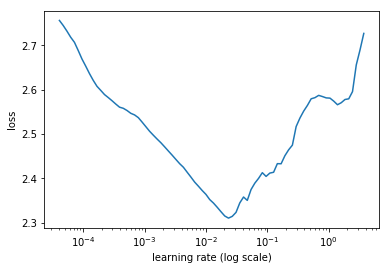

In [45]:
learn.sched.plot()

In [8]:
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(lr/200,lr/10), lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=7, lr=(lr/10,lr/2), lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=7, lr=(lr/2,lr/10), lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=3, lr=(lr/10,lr/100), lr_decay=DecayType.LINEAR)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.662039   1.696292   0.4442    
    1      1.27336    1.260788   0.5661                   
    2      0.945429   0.897295   0.6936                    
    3      0.752769   0.730798   0.7485                    
    4      0.60563    0.621861   0.7854                    
    5      0.526326   0.627241   0.7945                    
    6      0.471621   0.631171   0.7822                    
    7      0.44156    0.492612   0.8355                    
    8      0.380013   0.399317   0.8605                    
    9      0.317966   0.3809     0.8725                    
    10     0.271654   0.344888   0.8875                    
    11     0.240416   0.326707   0.8964                    
    12     0.192542   0.324715   0.8984                    
    13     0.154397   0.266097   0.9105                    
    14     0.121361   0.263755   0.9175                    
    15     0.092432   0.244981   0.9272                   

[array([0.23983]), 0.9285000017166137]

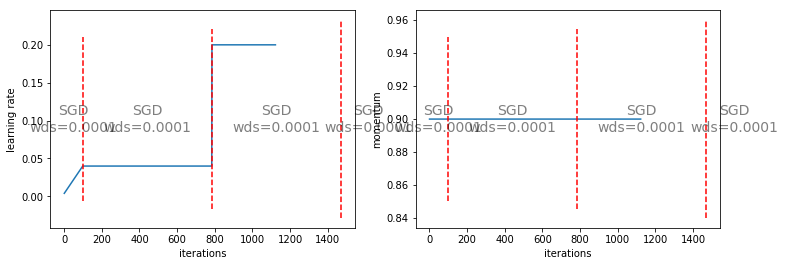

In [19]:
learn.sched.plot_lr()

In [14]:
%time learn.fit(.005, 1, wds=wd, cycle_len=1, loss_scale=512)

 51%|█████     | 50/98 [00:07<00:07,  6.64it/s, loss=2.31]

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.986074   1.823489   0.3445    

CPU times: user 10.1 s, sys: 4.47 s, total: 14.6 s
Wall time: 15.3 s


[array([1.82349]), 0.34450000104904177]

In [15]:
%time learn.fit(lr, 1, wds=wd, cycle_len=20, use_clr_beta=(12,15,0.95,0.85), loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.752462   2.089988   0.3653    
    1      1.415329   1.277752   0.5432                   
    2      1.03773    0.896488   0.6782                   
    3      0.813492   0.775105   0.7253                    
    4      0.684075   0.725958   0.749                     
    5      0.573127   0.63228    0.7859                    
    6      0.515764   0.531604   0.8106                    
    7      0.473965   0.660552   0.7841                    
    8      0.418588   0.505136   0.8285                    
    9      0.364027   0.452368   0.8493                    
    10     0.328663   0.418461   0.8598                    
    11     0.293754   0.410593   0.8596                    
    12     0.269821   0.346743   0.8836                    
    13     0.236393   0.305855   0.8981                    
    14     0.190974   0.316761   0.8996                    
    15     0.161148   0.289981   0.9077                    

[array([0.24707]), 0.9243000017166138]